In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    accuracy_score,
)
from scipy.optimize import linear_sum_assignment

# A

n_samples:  1797
n_features:  64
n_classes:  10


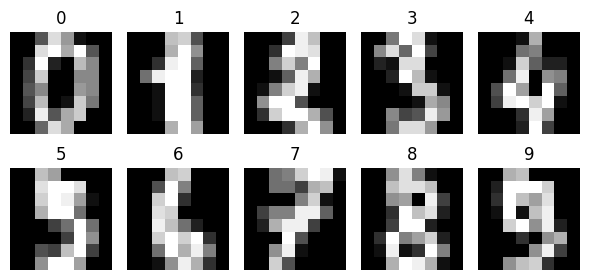

In [14]:
digits = load_digits()
X = digits.data
y = digits.target

print("n_samples: ", X.shape[0])
print("n_features: ", X.shape[1])
print("n_classes: ", len(np.unique(y)))

X_scaled = StandardScaler().fit_transform(X)
fig, axes = plt.subplots(2, 5, figsize=(6, 3))
for ax, img, label in zip(axes.ravel(), digits.images, y):
    ax.imshow(img, cmap="gray")
    ax.set_title(str(label))
    ax.axis("off")
plt.tight_layout()
plt.show()

# B

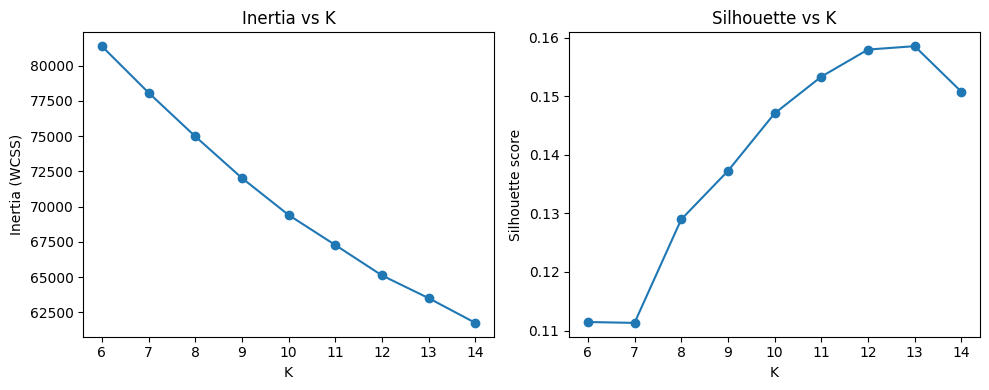

In [15]:
Ks = range(6, 15)
inertias = []        # خطا: هرچه کمتر باشد نقطه ها به مرکز نزدیکترند
sil_scores = []      # جدایی خوشه ها از -۱ تا ۱

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    labels_k = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels_k))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(Ks, inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia (WCSS)")
plt.title("Inertia vs K")

plt.subplot(1, 2, 2)
plt.plot(Ks, sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs K")
plt.tight_layout()
plt.show()


# G

In [16]:
best_K = 13
print("Chosen K:", best_K)
n_runs = 10
run_inertias = []
all_labels = []

for seed in range(n_runs):
    km = KMeans(n_clusters=best_K, n_init=1, random_state=seed)
    labels_run = km.fit_predict(X_scaled)
    run_inertias.append(km.inertia_)
    all_labels.append(labels_run)

print("Inertias over runs:", run_inertias)
print("min inertia:", np.min(run_inertias))
print("max inertia:", np.max(run_inertias))
print("std inertia:", np.std(run_inertias))


Chosen K: 13
Inertias over runs: [63638.616508868625, 65005.25108553088, 63596.78858466415, 65062.0826764542, 66141.41084979923, 65967.34534735262, 65350.436931273536, 63447.49964435039, 65037.14368798517, 65455.7238457153]
min inertia: 63447.49964435039
max inertia: 66141.41084979923
std inertia: 929.4379697139632


# H

In [17]:
def best_cluster_label_mapping(y_true, y_pred): # Hungarian
    classes = np.unique(y_true)
    clusters = np.unique(y_pred)

    cost_matrix = np.zeros((clusters.size, classes.size), dtype=int)
    for i, c in enumerate(clusters):
        for j, cl in enumerate(classes):
            cost_matrix[i, j] = np.sum((y_pred == c) & (y_true == cl))

    max_val = cost_matrix.max()
    cost_matrix = max_val - cost_matrix

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping_array = np.zeros(clusters.max() + 1, dtype=int)
    for r, c in zip(row_ind, col_ind):
        cluster_id = clusters[r]
        class_id = classes[c]
        mapping_array[cluster_id] = class_id

    return mapping_array

In [18]:
km = KMeans(n_clusters=best_K, n_init=20, random_state=42)
cluster_labels = km.fit_predict(X_scaled)

mapping_array = best_cluster_label_mapping(y, cluster_labels)
mapped_labels = mapping_array[cluster_labels]

acc = accuracy_score(y, mapped_labels)
ari = adjusted_rand_score(y, cluster_labels)
nmi = normalized_mutual_info_score(y, cluster_labels)

print("Accuracy after Hungarian mapping:", acc)
print("ARI:", ari)
print("NMI:", nmi)


Accuracy after Hungarian mapping: 0.6599888703394546
ARI: 0.5505648583536152
NMI: 0.678327100796514


# E
short discussion (you write in your report)

نقاط قوت K-Means روی digits
روی دیتاست digits ساختار کلی بسیاری از ارقام را تا حد خوبی جدا می‌کند، چون هر کلاس (مثلاً «۰» یا «۱») معمولاً حول یک مرکز میانگین نسبتاً مشخص در فضای ویژگی‌های ۶۴بعدی پخش شده است.

الگوریتم از نظر محاسباتی ساده و سریع است و با داده‌ی نسبتاً بزرگ digits هم به‌خوبی مقیاس‌پذیر است؛ بنابراین برای یک baseline بدون ناظر روی تصاویر ارقام گزینه‌ی مناسبی است.


محدودیت‌ها و مشکلات K-Means روی digits
فرض K-Means این است که خوشه‌ها تقریباً کروی و با واریانس مشابه باشند، درحالی‌که در digits بعضی ارقام چند زیرشکل مختلف دارند (مثلاً ۴ به شکل‌های مختلف نوشته می‌شود) و در نتیجه توزیع آن‌ها چند مدی و پیچیده است و به‌خوبی با یک مرکز واحد مدل نمی‌شود.


بعضی ارقام از نظر شکل پیکسل‌ها خیلی به هم شبیه‌اند، مثل ۳ و ۵ یا ۴ و ۹؛ این شباهت باعث می‌شود نواحی این کلاس‌ها در فضای ویژگی‌ها روی هم بیفتد و K-Means آن‌ها را در یک خوشه مخلوط کند یا مرز را اشتباه بگذارد، حتی اگر معیارهایی مثل WCSS یا سیلوئت عدد بدی نشان ندهند.
